## 1. Polars: Read CSV


In [13]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/bikes.csv

--2024-11-07 07:49:01--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/bikes.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.149.162, 52.95.142.94, 3.5.244.229, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.149.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13807 (13K) [text/csv]
Saving to: ‘bikes.csv.2’

bikes.csv.2         100%[===================>]  13.48K  --.-KB/s    in 0s      

2024-11-07 07:49:02 (133 MB/s) - ‘bikes.csv.2’ saved [13807/13807]



In [1]:
#path = "bikes.csv"
path = "https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/bikes.csv"

In [2]:
import polars as pl
import polars.selectors as cs
import seaborn as sbn
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

print(pl.__version__)

0.20.31


# 1.1 Reading data from a csv file

You can read data from a CSV file using the `read_csv` function. By default, it assumes that the fields are comma-separated.

We're going to be looking some cyclist data from Montréal. Here's the [original page](http://donnees.ville.montreal.qc.ca/dataset/velos-comptage) (in French), but it's already included in this repository. We're using the data from 2012.

This dataset is a list of how many people were on 7 different bike paths in Montreal, each day.

In [3]:
broken_df = pl.read_csv(path,encoding = "ISO-8859-1")
# Look at the first 3 rows
broken_df.head(3)

Date;Berri 1;Brébeuf (données non disponibles);Côte-Sainte-Catherine;Maisonneuve 1;Maisonneuve 2;du Parc;Pierre-Dupuy;Rachel1;St-Urbain (données non disponibles)
str
"""01/01/2012;35;;0;38;51;26;10;1…"
"""02/01/2012;83;;1;68;153;53;6;4…"
"""03/01/2012;135;;2;104;248;89;3…"


You'll notice that this is totally broken! `read_csv` has a bunch of options that will let us fix that, though. Here we'll

* change the column separator to a `;`
* Set the encoding to `'latin1'` (the default is `'utf8'`)
* Attempt to parse all date columns

In [5]:
fixed_df = pl.read_csv(path,
                       separator=';',
                       encoding='latin1',
                       try_parse_dates=True,
                       schema_overrides={'Brébeuf (données non disponibles)': pl.Int64,
                               'St-Urbain (données non disponibles)': pl.Int64}
                        )
fixed_df.head(3)

Date,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
date,i64,i64,i64,i64,i64,i64,i64,i64,i64
2012-01-01,35,null,0,38,51,26,10,16,null
2012-01-02,83,null,1,68,153,53,6,43,null
2012-01-03,135,null,2,104,248,89,3,58,null


# 1.2 Selecting a column

When you read a CSV, you get a kind of object called a `DataFrame`, which is made up of rows and columns. You get columns out of a DataFrame the same way you get elements out of a dictionary.

Here's an example:

In [6]:
fixed_df['Berri 1']

Berri 1
i64
35
83
135
144
197
…
2405
1582
844


# 1.3 Plotting a column

We can see that, unsurprisingly, not many people are biking in January, February, and March,

<Axes: xlabel='Date', ylabel='Berri 1'>

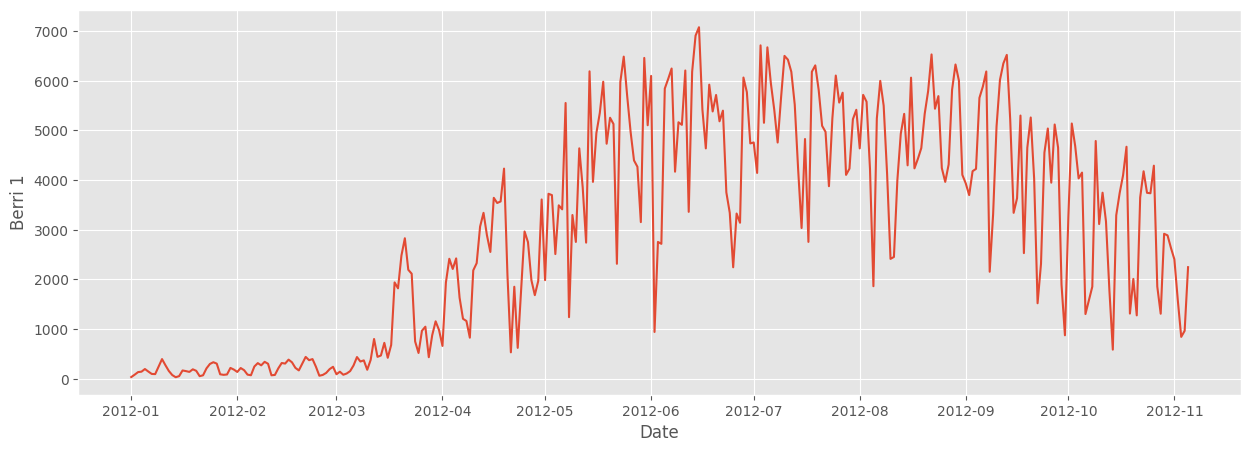

In [7]:
sbn.lineplot(fixed_df, x='Date', y='Berri 1')

We can also plot all the columns just as easily. We'll make it a little bigger, too.
You can see that it's more squished together, but all the bike paths behave basically the same -- if it's a bad day for cyclists, it's a bad day everywhere.

In [12]:
melt_df = (fixed_df
           .select(pl.exclude(pl.Utf8))
           .unpivot(index='Date', variable_name='trail', value_name='distance')
           )
with plt.rc_context({'figure.figsize': (15, 10)}):
    sbn.lineplot(melt_df, x='Date', y='distance', hue='trail')

AttributeError: 'DataFrame' object has no attribute 'unpivot'

# 1.4 Putting all that together

Here's the code we needed to write do draw that graph, all together:

<Axes: xlabel='Date', ylabel='Berri 1'>

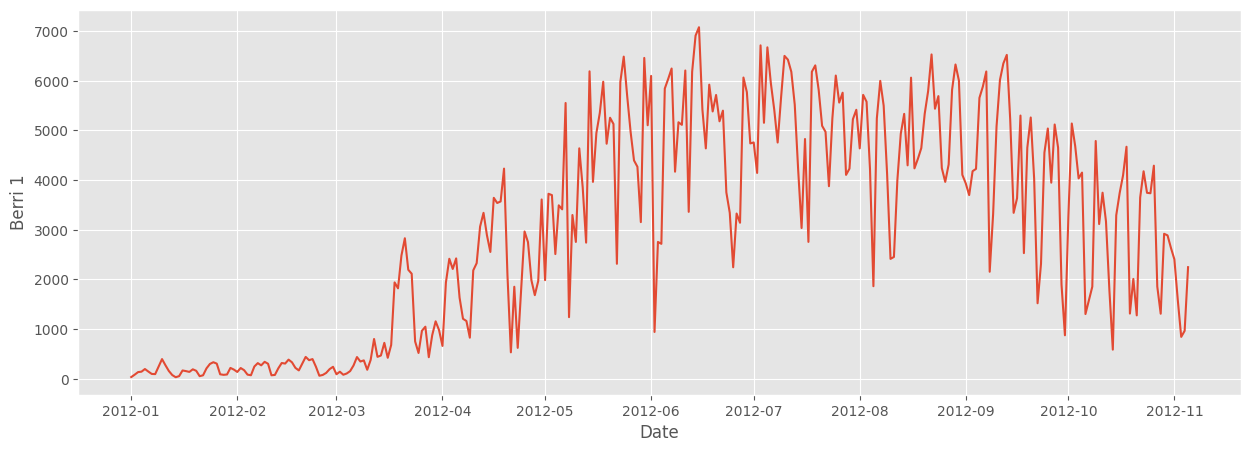

In [9]:
fixed_df = pl.read_csv(path,
                       separator=';',
                       encoding='latin1',
                       try_parse_dates=True)

sbn.lineplot(fixed_df, x='Date', y='Berri 1')

In [22]:
#end

<style>
    @font-face {
        font-family: "Computer Modern";
        src: url('http://mirrors.ctan.org/fonts/cm-unicode/fonts/otf/cmunss.otf');
    }
    div.cell{
        width:800px;
        margin-left:16% !important;
        margin-right:auto;
    }
    h1 {
        font-family: Helvetica, serif;
    }
    h4{
        margin-top:12px;
        margin-bottom: 3px;
       }
    div.text_cell_render{
        font-family: Computer Modern, "Helvetica Neue", Arial, Helvetica, Geneva, sans-serif;
        line-height: 145%;
        font-size: 130%;
        width:800px;
        margin-left:auto;
        margin-right:auto;
    }
    .CodeMirror{
            font-family: "Source Code Pro", source-code-pro,Consolas, monospace;
    }
    .text_cell_render h5 {
        font-weight: 300;
        font-size: 22pt;
        color: #4057A1;
        font-style: italic;
        margin-bottom: .5em;
        margin-top: 0.5em;
        display: block;
    }
    
    .warning{
        color: rgb( 240, 20, 20 )
        }  